In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from sklearn.metrics import confusion_matrix,accuracy_score

In [3]:
data = pd.read_csv('mpst_full_data.csv', sep=',')
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [103]:
data.describe()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
count,14828,14828,14828,14828,14828,14828
unique,14828,13757,13848,5604,3,2
top,tt0494232,Beauty and the Beast,Dragon Ball Z picks up five years after the en...,murder,train,wikipedia
freq,1,10,12,1004,9489,10656


In [104]:
data.isnull().sum()

imdb_id            0
title              0
plot_synopsis      0
tags               0
split              0
synopsis_source    0
dtype: int64

In [4]:
imdb_id = data.imdb_id
plot = data.plot_synopsis

movies = pd.DataFrame({'imdb_id': imdb_id, 'plot': plot})
movies.head()

,imdb_id,plot
0,tt0057603,Note: this synopsis is for the orginal Italian...
1,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s..."
2,tt0033045,"Matuschek's, a gift store in Budapest, is the ..."
3,tt0113862,"Glenn Holland, not a morning person by anyone'..."
4,tt0086250,"In May 1980, a Cuban man named Tony Montana (A..."


In [5]:
data['imdb_id'] = data['imdb_id'].astype(str)
movies = pd.merge(movies, data[['imdb_id', 'title', 'tags', 'split']], on='imdb_id')
movies.head()

,imdb_id,plot,title,tags,split
0,tt0057603,Note: this synopsis is for the orginal Italian...,I tre volti della paura,"cult, horror, gothic, murder, atmospheric",train
1,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",Dungeons & Dragons: The Book of Vile Darkness,violence,train
2,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",The Shop Around the Corner,romantic,test
3,tt0113862,"Glenn Holland, not a morning person by anyone'...",Mr. Holland's Opus,"inspiring, romantic, stupid, feel-good",train
4,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...",Scarface,"cruelty, murder, dramatic, cult, violence, atm...",val


In [6]:
genres_listas = []

for tag in movies.tags:
    genres_listas.append(re.split(',', tag))

movies.tags = genres_listas

In [7]:
all_genres = sum(genres_listas, [])
for i in range(0, len(all_genres)):
    all_genres[i] = all_genres[i].strip()
print(len(set(all_genres)))

71


In [8]:
all_genres

['cult',
 'horror',
 'gothic',
 'murder',
 'atmospheric',
 'violence',
 'romantic',
 'inspiring',
 'romantic',
 'stupid',
 'feel-good',
 'cruelty',
 'murder',
 'dramatic',
 'cult',
 'violence',
 'atmospheric',
 'action',
 'romantic',
 'revenge',
 'sadist',
 'romantic',
 'queer',
 'flashback',
 'gothic',
 'cruelty',
 'violence',
 'cult',
 'revenge',
 'sadist',
 'mystery',
 'suspenseful',
 'action',
 'murder',
 'flashback',
 'violence',
 'revenge',
 'neo noir',
 'murder',
 'violence',
 'flashback',
 'cult',
 'prank',
 'cult',
 'psychedelic',
 'murder',
 'violence',
 'tragedy',
 'dramatic',
 'murder',
 'murder',
 'flashback',
 'autobiographical',
 'home movie',
 'good versus evil',
 'suspenseful',
 'depressing',
 'realism',
 'boring',
 'murder',
 'cult',
 'violence',
 'atmospheric',
 'haunting',
 'romantic',
 'sentimental',
 'flashback',
 'paranormal',
 'horror',
 'haunting',
 'suspenseful',
 'neo noir',
 'murder',
 'violence',
 'action',
 'revenge',
 'romantic',
 'historical',
 'storytel

In [9]:
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

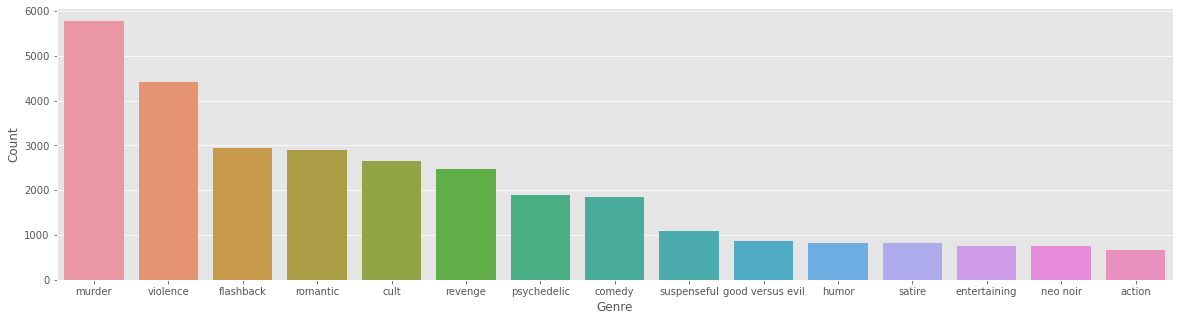

In [120]:
plt.style.use('ggplot')
g = all_genres_df.nlargest(columns='Count', n=15)
plt.figure(figsize=(20,5))
ax = sns.barplot(data=g, x='Genre', y='Count')
ax.set(ylabel='Count')
plt.show()

In [121]:
# function untuk text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text ke lowercase 
    text = text.lower() 
    return text

In [122]:
import copy
movies_new = copy.deepcopy(movies)
movies_new['clean_plot'] = movies['plot'].apply(lambda x: clean_text(x))
movies_new.head()

,imdb_id,plot,title,tags,split,clean_plot
0,tt0057603,Note: this synopsis is for the orginal Italian...,I tre volti della paura,"[cult, horror, gothic, murder, atmospheric]",train,note this synopsis is for the orginal italian ...
1,tt1733125,"Two thousand years ago, Nhagruul the Foul, a s...",Dungeons & Dragons: The Book of Vile Darkness,[violence],train,two thousand years ago nhagruul the foul a sor...
2,tt0033045,"Matuschek's, a gift store in Budapest, is the ...",The Shop Around the Corner,[romantic],test,matuscheks a gift store in budapest is the wor...
3,tt0113862,"Glenn Holland, not a morning person by anyone'...",Mr. Holland's Opus,"[inspiring, romantic, stupid, feel-good]",train,glenn holland not a morning person by anyones ...
4,tt0086250,"In May 1980, a Cuban man named Tony Montana (A...",Scarface,"[cruelty, murder, dramatic, cult, violence...",val,in may a cuban man named tony montana al pacin...


In [130]:
def freq_words(x, terms = 15):
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 15 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(15,5)) 
    ax = sns.barplot(data=d, x= "word", y = "count") 
    ax.set(ylabel = 'Count') 
    plt.show()

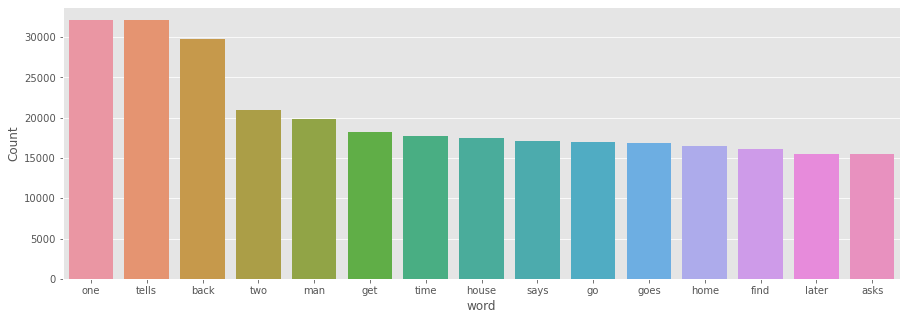

In [131]:
#print 15 most frequent words 
freq_words(movies_new['clean_plot'], 15)

In [132]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Widows\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


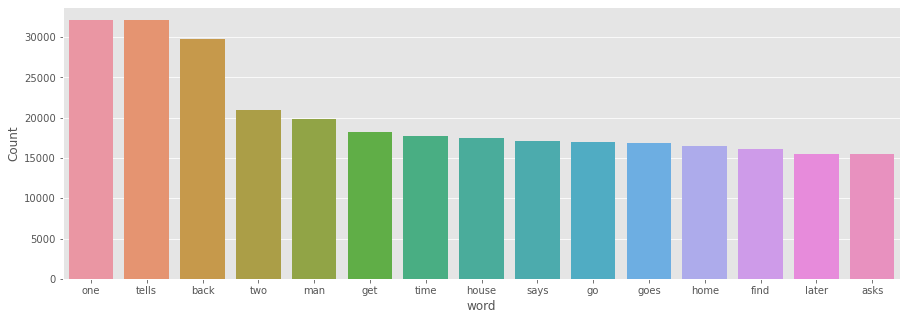

In [133]:
freq_words(movies_new['clean_plot'], 15)

In [134]:
mlb = MultiLabelBinarizer()
mlb.fit(movies_new[movies_new['split'] == 'train']['tags'])
y = mlb.transform(movies_new[movies_new['split'] == 'train']['tags'])

In [135]:
y.shape

(9489, 142)

In [136]:
movies_new = pd.concat([movies_new, pd.DataFrame(y, columns=mlb.classes_)], axis=1)
print(len(movies_new.columns))
movies_new.columns

148


Index(['imdb_id', 'plot', 'title', 'tags', 'split', 'clean_plot', ' absurd',
       ' action', ' adult comedy', ' allegory',
       ...
       'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful',
       'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical'],
      dtype='object', length=148)

In [137]:
counts = []
genres = mlb.classes_
split = []
for genre in genres:
    counts.append((genre, movies_new[genre].sum()))
movies_new_stats = pd.DataFrame(counts, columns=['genres', 'plots'])

In [138]:
print(len(movies_new.columns))
genres = movies_new_stats.loc[movies_new_stats['plots'] > 100, 'genres'].tolist()
movies_new.drop(movies_new_stats.loc[movies_new_stats['plots'] < 100, 'genres'].tolist(), axis=1, inplace=True)
len(movies_new.columns)

148


66

In [139]:
mlb = MultiLabelBinarizer()
mlb.fit(movies_new[movies_new['split'] == 'train']['tags'])

MultiLabelBinarizer()

In [140]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [141]:
y = movies_new[movies_new['split'] == 'train'].iloc[:, 6:len(movies_new.columns)+1]
y.fillna(1, inplace=True)
y = np.array(y)

In [142]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(movies_new[movies_new['split'] == 'train']['clean_plot'])
xtrain_tfidf

<9489x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2420734 stored elements in Compressed Sparse Row format>

In [143]:
xtest_tfidf = tfidf_vectorizer.fit_transform(movies_new[movies_new['split'] == 'test']['clean_plot'])
xtest_tfidf

<2966x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 768417 stored elements in Compressed Sparse Row format>

In [144]:
clf = MultinomialNB()

In [145]:
i = 0
t = []

while i <= y.shape[1]-1:
    s = []
    clf.fit(xtrain_tfidf, y[:,i])
    s.append(clf.predict(xtest_tfidf))
    i += 1
    t.append(s)

In [146]:
y_pred = np.array(t).reshape(np.array(t).shape[2], np.array(t).shape[0])
y_pred.shape

(2966, 60)

In [147]:
y_true = movies_new[movies_new['split'] == 'test'].iloc[:, 6:len(movies_new.columns)+1]
y_true.fillna(1, inplace=True)

In [148]:
y_true = np.array(y_true)

In [149]:
print(y_pred.shape)
print(y_true.shape)

(2966, 60)
(2966, 60)


In [150]:
sklearn.metrics.f1_score(y_true, y_pred, average='micro')

0.3442324350142074

In [151]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.31      0.34      1071
           1       0.39      0.32      0.35      1130
           2       0.36      0.31      0.33      1066
           3       0.38      0.32      0.35      1095
           4       0.38      0.33      0.35      1099
           5       0.38      0.32      0.35      1133
           6       0.37      0.31      0.33      1089
           7       0.40      0.29      0.34      1252
           8       0.36      0.30      0.33      1072
           9       0.37      0.31      0.34      1074
          10       0.37      0.30      0.33      1122
          11       0.39      0.33      0.36      1089
          12       0.47      0.31      0.37      1377
          13       0.37      0.30      0.33      1109
          14       0.38      0.31      0.34      1102
          15       0.37      0.30      0.33      1084
          16       0.37      0.32      0.34      1098
          17       0.37    

D:\Application\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [152]:
sklearn.metrics.multilabel_confusion_matrix(y_true, y_pred)

array([[[1317,  578],
        [ 738,  333]],

       [[1277,  559],
        [ 771,  359]],

       [[1312,  588],
        [ 734,  332]],

       [[1293,  578],
        [ 746,  349]],

       [[1284,  583],
        [ 741,  358]],

       [[1259,  574],
        [ 775,  358]],

       [[1299,  578],
        [ 754,  335]],

       [[1164,  550],
        [ 888,  364]],

       [[1306,  588],
        [ 748,  324]],

       [[1308,  584],
        [ 737,  337]],

       [[1263,  581],
        [ 781,  341]],

       [[1327,  550],
        [ 735,  354]],

       [[1099,  490],
        [ 949,  428]],

       [[1282,  575],
        [ 776,  333]],

       [[1298,  566],
        [ 757,  345]],

       [[1314,  568],
        [ 754,  330]],

       [[1272,  596],
        [ 745,  353]],

       [[1227,  593],
        [ 803,  343]],

       [[1267,  602],
        [ 775,  322]],

       [[1308,  568],
        [ 746,  344]],

       [[ 931,  412],
        [1115,  508]],

       [[1286,  586],
        [ 74